In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# last day for selected date range
last_date = session.query(measurement.date, measurement.prcp).order_by(measurement.date.desc()).first()[0]

# change the data type into date format
entered_date = dt.datetime.strptime(last_date, "%Y-%m-%d")
entered_date = entered_date.date()

# Calculate the date from 1 year ago from the last data point in the database
one_yr_ago = entered_date - dt.timedelta(days = 365)
one_yr_ago


datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the data and precipitation scores
# Query 'measurement_date, measurement_prcp' and save into one_yr_precp

one_yr_precp = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_yr_ago).\
    filter(measurement.date <= last_date).all()

In [26]:
# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(one_yr_precp, columns=['date', 'prcp'])
df.set_index('date', inplace = True)
df.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13


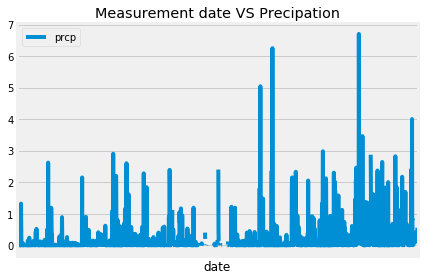

In [33]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xticks([])
plt.title("Measurement date VS Precipation")
plt.savefig("Images/precipitation_vs_date.jpg")
plt.tight_layout()
plt.show()

## Station Analysis

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [36]:
# Design a query to show how many stations are available in this dataset?
station_ct = session.query(measurement.station).distinct().count()
print("station count:", station_ct)

station count: 9


In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
        order_by(func.count(measurement.station).desc()).all()

active_stations_df = pd.DataFrame(active_stations, columns=["Station", "Data Count"])
active_stations_df.head()

,Station,Data Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [65]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
activest_station = active_stations[0][0]
activest_station

sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]

activest_station_tobs = session.query(*sel).\
    filter(measurement.station==activest_station).all()[0]

print(f"Tempurature Minimum: {activest_station_tobs[0]}")
print(f"Tempurature Average: {activest_station_tobs[1]}")
print(f"Tempurature Maximum: {activest_station_tobs[2]}")

Tempurature Minimum: 54.0
Tempurature Average: 71.66378066378067
Tempurature Maximum: 85.0


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_tobs = session.query(measurement.tobs).\
    filter(measurement.date >= one_yr_ago).\
    filter(measurement.date <= last_date).\
    filter(measurement.station == activest_station).all()

tobs_array = np.ravel(station_tobs)



## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
